**Support Vector Machine (SVM) Overview**

**Support Vector Machine (SVM)** is a supervised learning algorithm commonly used for **classification** and **regression** tasks. It operates by finding the **optimal hyperplane** that separates different classes with the **maximum margin**, focusing on the most challenging data points—known as **support vectors**.

🔑 Key Features:
- **Margin Maximization:** Targets the hardest-to-classify points to maximize decision boundary confidence.
- **Kernel Trick:** Efficiently handles non-linear separations by mapping data into higher-dimensional space (e.g., RBF, polynomial kernels).
- **Regularization (`C` parameter):** Controls the trade-off between maximizing the margin and minimizing classification errors.
- **Versatility:** Performs well on high-dimensional data such as text and image datasets.

✅ Strengths:
- Effective in **high-dimensional spaces**.
- **Robust to overfitting** with appropriate regularization.
- **Memory-efficient**, using only support vectors for prediction.

⚠️ Weaknesses:
- **Computationally intensive** for large datasets.
- Requires careful **kernel and hyperparameter tuning** (`C`, `gamma`, etc.).
- **Less interpretable** compared to decision tree-based models.



#**Import library**

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8e004c9b4c78430a635655ca693bd9c1dfc2bd3d26ac8fc61cb521a6a3042cab
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import time
import shap
from lime import lime_tabular
# import eli5
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE  # For SMOTE resampling

# **Read the dataset**

In [ ]:
# Load and prepare data
df = pd.read_csv("/content/df_cleaned.csv")
print("Dataset loaded successfully")

Dataset loaded successfully


In [ ]:
df.head()

,last_pymnt_d,total_rec_prncp,last_pymnt_amnt,out_prncp,total_rec_late_fee,last_fico_range_high,installment,loan_amnt,total_rec_int,out_prncp_inv,...,funded_amnt_inv,recoveries,debt_settlement_flag,hardship_flag,mo_sin_old_rev_tl_op,revol_util,dti,all_util,annual_inc,loan_status
0,17,-0.332581,-0.372797,0.420080,-0.261895,0.281611,-0.473027,-0.461473,0.413942,0.420298,...,-0.461004,-0.445598,0,0,-0.307356,0.608376,0.558953,0.915820,-1.203816,0
1,31,-0.840560,-0.473603,-0.629220,-0.261895,1.244049,-1.608631,-1.601510,-1.081823,-0.629167,...,-1.601271,-0.445598,0,0,-0.187187,-1.880835,-1.233491,-0.049124,0.274631,1
2,27,-0.250720,-0.222228,2.263937,-0.261895,0.883135,1.252073,1.058575,-0.380182,2.264445,...,1.059353,-0.445598,0,0,-0.980297,0.431193,-0.223328,0.379740,2.227297,1
3,39,-0.458023,0.161605,-0.629220,-0.261895,0.161306,-1.364264,-1.373503,-0.909433,-0.629167,...,-1.373218,-0.445598,0,0,-1.472987,0.314511,-0.337836,0.433348,-1.231711,1
4,5,-0.415519,0.220569,-0.629220,-0.261895,0.221459,-1.317547,-1.348168,-0.834440,-0.629167,...,-1.347878,-0.445598,0,0,0.738107,1.273894,0.117928,1.559116,-0.841178,1


In [ ]:
df.shape

(119286, 21)

In [ ]:
# Check for missing values
print("Missing values count:")
df.isna().sum()

Missing values count:


,0
last_pymnt_d,0
total_rec_prncp,0
last_pymnt_amnt,0
out_prncp,0
total_rec_late_fee,0
last_fico_range_high,0
installment,0
loan_amnt,0
total_rec_int,0
out_prncp_inv,0


In [ ]:
# Data Cleaning - Remove duplicate samples
df = df.drop_duplicates()
print(f"\nDataset shape after removing duplicates: {df.shape}")


Dataset shape after removing duplicates: (119286, 21)


In [ ]:
# Print all column names
print("\nAll columns in the dataset:")
df.columns.tolist()


All columns in the dataset:


['last_pymnt_d',
 'total_rec_prncp',
 'last_pymnt_amnt',
 'out_prncp',
 'total_rec_late_fee',
 'last_fico_range_high',
 'installment',
 'loan_amnt',
 'total_rec_int',
 'out_prncp_inv',
 'total_pymnt',
 'funded_amnt_inv',
 'recoveries',
 'debt_settlement_flag',
 'hardship_flag',
 'mo_sin_old_rev_tl_op',
 'revol_util',
 'dti',
 'all_util',
 'annual_inc',
 'loan_status']

In [ ]:
# Encode categorical variables using integer encoding (as per Equation 1 in the paper)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded categorical column: {col}")

In [ ]:
print("\nOriginal class distribution:")
print(df['loan_status'].value_counts(normalize=True))


Original class distribution:
loan_status
1    0.520145
0    0.479855
Name: proportion, dtype: float64


In [ ]:
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [ ]:
print(f"\nFinal training set shape: {X_train.shape}")
print(f"Final test set shape: {X_test.shape}")


Final training set shape: (95428, 20)
Final test set shape: (23858, 20)


# **Create SVM model based on specified parameters**

In [ ]:
def create_svm_model(model_type):
    """
    Create an SVM model based on specified parameters.

    Parameters:
    -----------
    model_type : str
        Type of SVM model to create: 'rbf', 'linear'

    Returns:
    --------
    sklearn.svm.SVC
        The configured SVM model
    """
    if model_type == 'rbf':
        # SVM RBF
        return svm.SVC(kernel='rbf', C=10, gamma=0.01, random_state=42, probability=True)
    elif model_type == 'linear':
        # SVM Linear
        return svm.SVC(kernel='linear', C=10, gamma=0.1, coef0=100, random_state=42, probability=True)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

In [ ]:
# Train and evaluate SVM models with different kernels
results = {}
model_types = ['rbf', 'linear']
display_names = ['RBF', 'Linear']
accuracies = []
training_times = []

In [ ]:
plt.figure(figsize=(15, 10))
# Train and evaluate each model type
for i, model_type in enumerate(model_types):
    print(f"\n--- Training SVM with {display_names[i]} Kernel ---")

    # Create model using the function
    start_time = time.time()
    model = create_svm_model(model_type)

    # Train model on the scaled data
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # Store results
    results[model_type] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'training_time': training_time,
        'y_pred': y_pred,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

    # Store for comparison
    accuracies.append(accuracy)
    training_times.append(training_time)

    # Print results
    print(f"{display_names[i]} Accuracy: {accuracy:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")


--- Training SVM with RBF Kernel ---
RBF Accuracy: 0.9896
Training time: 315.94 seconds
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     11448
           1       0.98      1.00      0.99     12410

    accuracy                           0.99     23858
   macro avg       0.99      0.99      0.99     23858
weighted avg       0.99      0.99      0.99     23858

Confusion Matrix:
[[11248   200]
 [   49 12361]]
F1 Score: 0.9900
ROC AUC: 0.9973

--- Training SVM with Linear Kernel ---
Linear Accuracy: 0.9650
Training time: 2778.87 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     11448
           1       0.96      0.98      0.97     12410

    accuracy                           0.96     23858
   macro avg       0.97      0.96      0.96     23858
weighted avg       0.97      0.96      0.96     23858

Confusion Matrix:
[[10881   567]


<Figure size 1500x1000 with 0 Axes>

In [ ]:
# Print detailed metrics for each model
for model_type, result in results.items():
    y_pred = result['y_pred']
    y_pred_proba = result['model'].predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n--- {model_type.upper()} Model Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")


--- RBF Model Metrics ---
Accuracy: 0.9896
F1 Score: 0.9900
ROC AUC: 0.9973

--- LINEAR Model Metrics ---
Accuracy: 0.9650
F1 Score: 0.9667
ROC AUC: 0.9945


# **Visualizations**

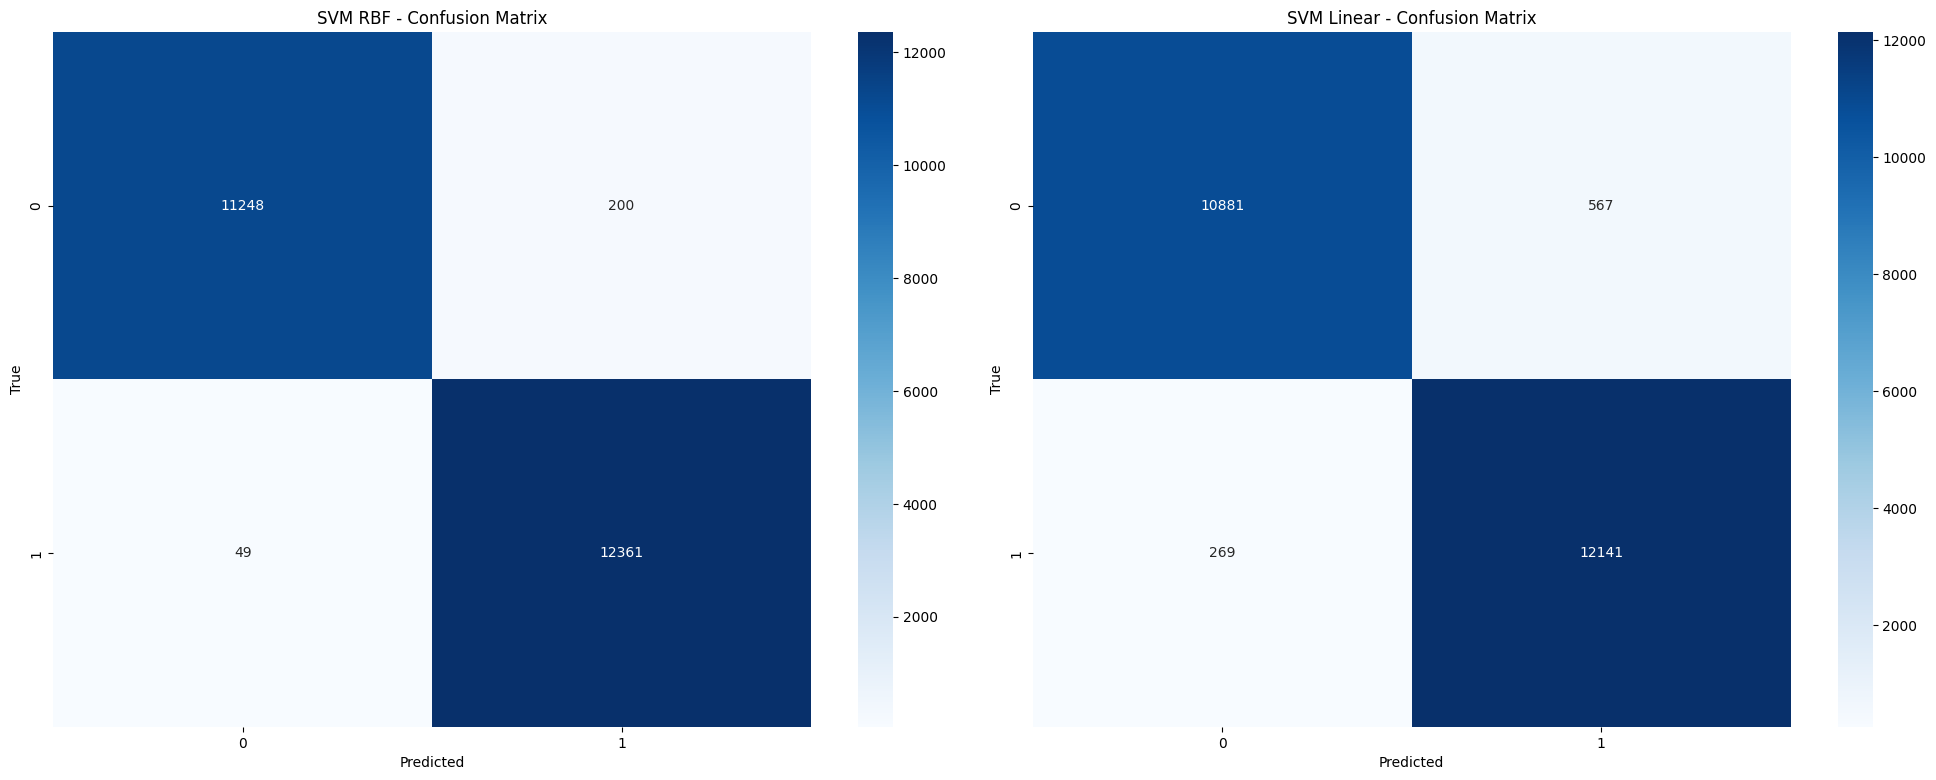

In [ ]:
# 1. Confusion matrices
plt.figure(figsize=(20, 15))
for i, model_type in enumerate(model_types):
    plt.subplot(2, 2, i+1)
    sns.heatmap(results[model_type]['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'SVM {display_names[i]} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.show()

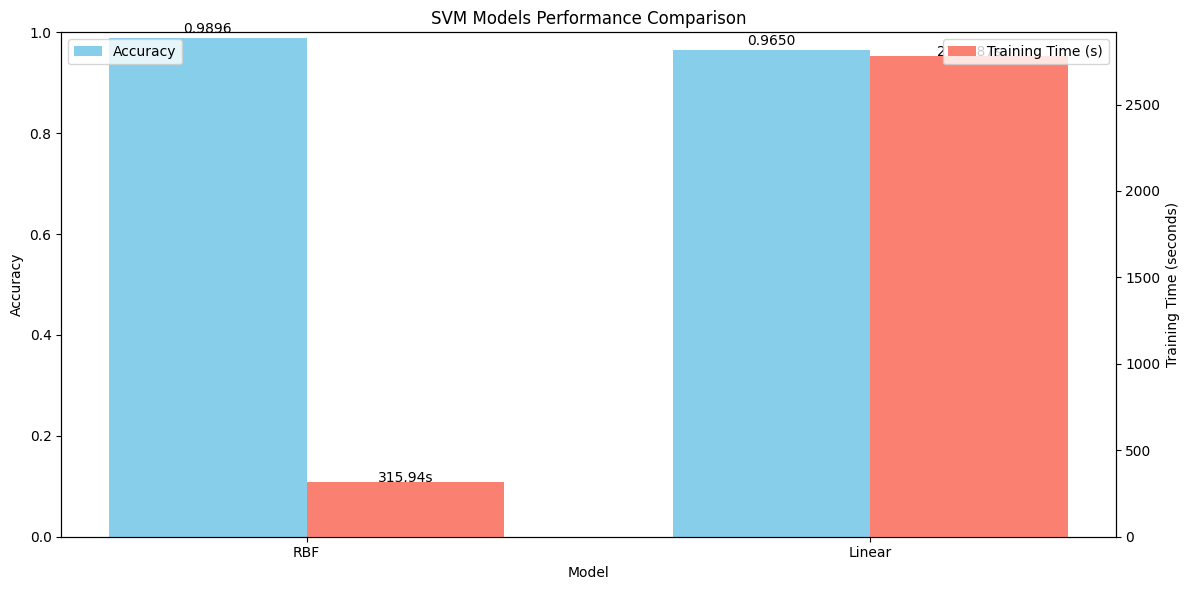

In [ ]:
# 2. Model performance comparison
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(111)
ax2 = ax1.twinx()
x = np.arange(len(display_names))
bar_width = 0.35

rects1 = ax1.bar(x - bar_width/2, accuracies, bar_width, label='Accuracy', color='skyblue')
rects2 = ax2.bar(x + bar_width/2, training_times, bar_width, label='Training Time (s)', color='salmon')

ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
ax2.set_ylabel('Training Time (seconds)')
ax1.set_xticks(x)
ax1.set_xticklabels(display_names)
ax1.set_title('SVM Models Performance Comparison')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

for i, v in enumerate(accuracies):
    ax1.text(i - bar_width/2, v + 0.01, f'{v:.4f}', ha='center')
for i, v in enumerate(training_times):
    ax2.text(i + bar_width/2, v + 0.1, f'{v:.2f}s', ha='center')

plt.tight_layout()
plt.show()

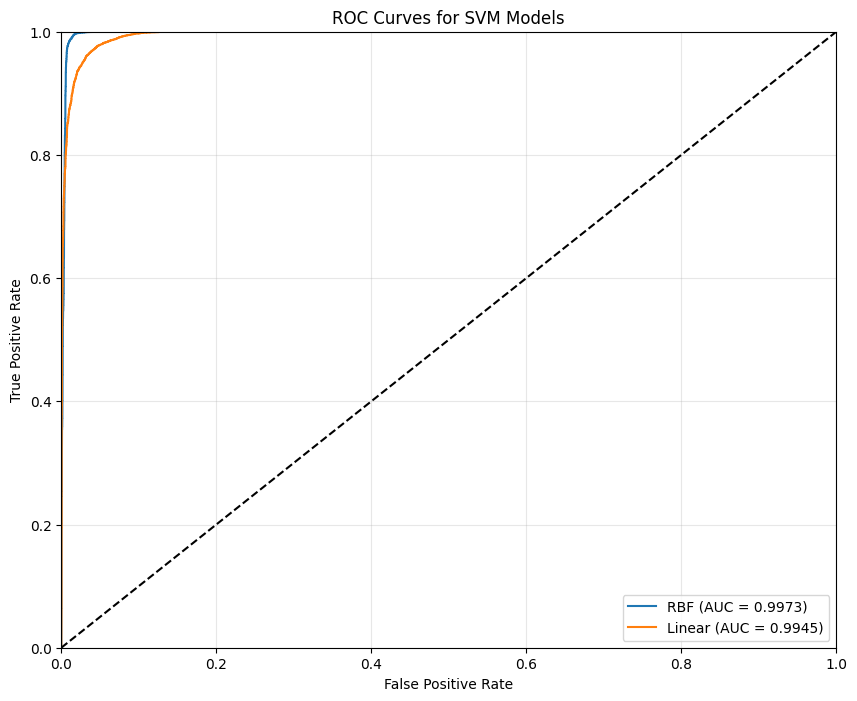

In [ ]:
# 3. ROC curves
plt.figure(figsize=(10, 8))
for i, model_type in enumerate(model_types):
    model = results[model_type]['model']
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{display_names[i]} (AUC = {roc_auc:.4f})')

# Add diagonal line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SVM Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# **EXPLAINABILITY TECHNIQUES**

In [ ]:
print("\n\n=== EXPLAINABILITY TECHNIQUES ===\n")
# Choose the best performing model for explainability analysis
best_model_type = model_types[np.argmax(accuracies)]
best_model = results[best_model_type]['model']
print(f"Using {best_model_type.upper()} kernel model for explainability analysis")

# Create a DataFrame with feature names for explainability
X_test_df = pd.DataFrame(X_test, columns=X.columns)




=== EXPLAINABILITY TECHNIQUES ===

Using RBF kernel model for explainability analysis


## **Global model**

### **1. Permutation Feature Importance**


--- EXPLAINABILITY #1: Permutation Importance ---


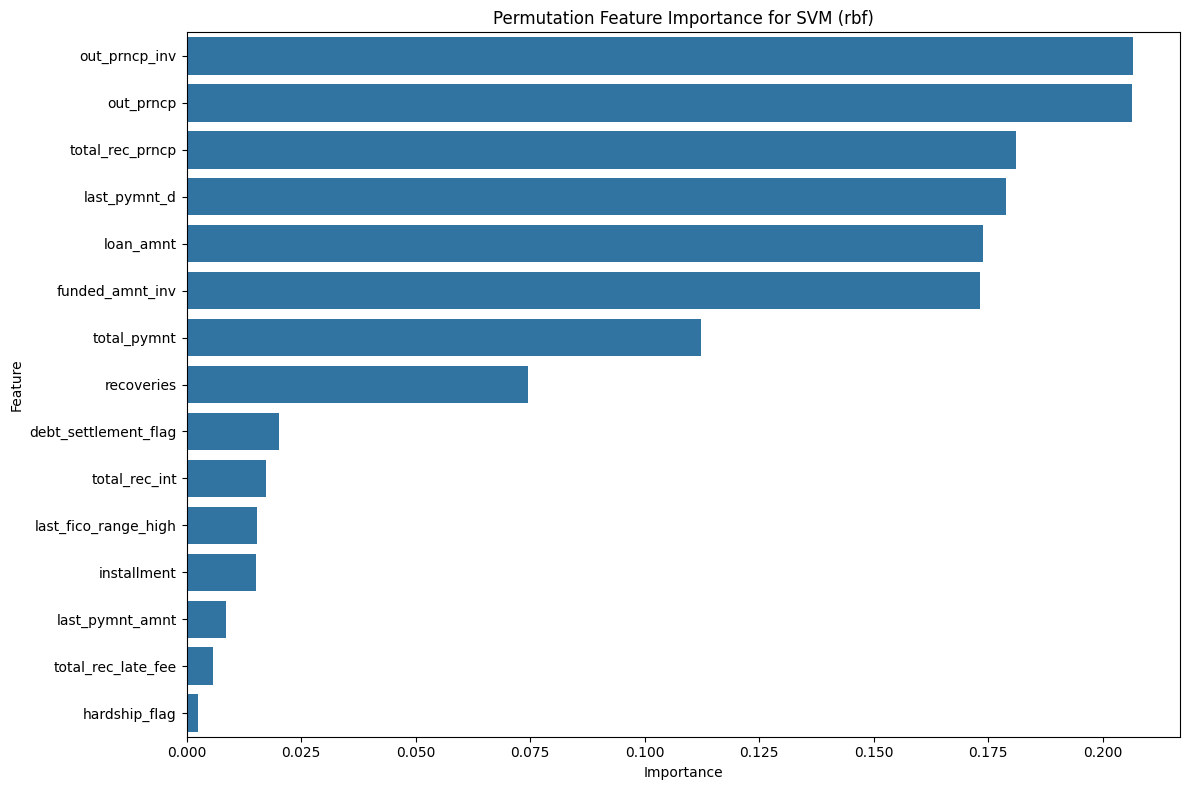

In [ ]:
print("\n--- EXPLAINABILITY #1: Permutation Importance ---")
perm = permutation_importance(best_model, X_test, y_test, random_state=42)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm.importances_mean
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title(f'Permutation Feature Importance for SVM ({best_model_type})')
plt.tight_layout()
plt.show()

In [ ]:
print("Top 10 most important features:")
print(feature_importances.head(10))

Top 10 most important features:
                 Feature  Importance
9          out_prncp_inv    0.206581
3              out_prncp    0.206505
1        total_rec_prncp    0.181113
0           last_pymnt_d    0.178825
7              loan_amnt    0.173837
11       funded_amnt_inv    0.173250
10           total_pymnt    0.112264
12            recoveries    0.074432
13  debt_settlement_flag    0.020169
8          total_rec_int    0.017353


Permutation Feature Importance – SVM (RBF Kernel)

This analysis shows how much each feature affects the model’s performance when its values are randomly shuffled. Higher importance scores indicate a stronger influence on predictions.

🔝 Top Features:
- **`out_prncp_inv`** and **`out_prncp`** (outstanding principal amounts)
- **`total_rec_prncip`** (total received principal)
- **`last_pymnt_d`** (last payment date)
- **`loan_amnt`** and **`funded_amnt_inv`** (loan size metrics)
- **`total_pymnt`** and **`recoveries`** (payment and recovery history)

These features have the **highest importance scores (~0.2)**, indicating a significant impact on the model’s predictions.

 🔽 Less Important Features:
- **`installment`**, **`last_pymnt_amnt`**, **`hardship_flag`**, and similar features show **very low importance** and have minimal effect when permuted.


### **2. (PDP) and (ICE) Plots**

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
print("\n--- EXPLAINABILITY #2: Partial Dependence Plots ---")
# Get top features from permutation importance
top_features = feature_importances['Feature'].head(1)
top_features


--- EXPLAINABILITY #2: Partial Dependence Plots ---


,Feature
9,out_prncp_inv


<ipython-input-37-2664b3d001f8>:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


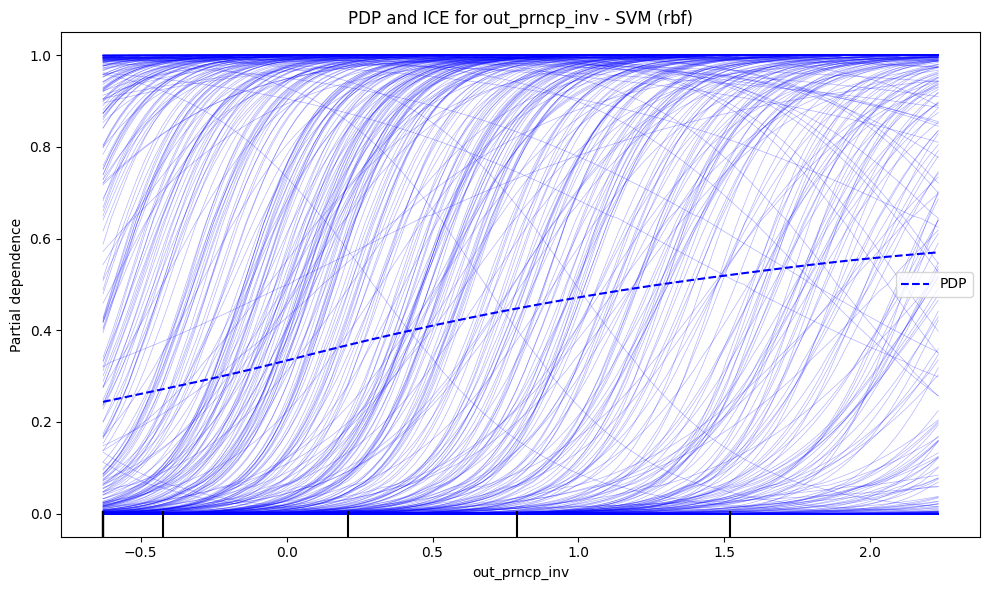

In [ ]:
sample_indices = np.random.choice(X_test.shape[0], size=1000, replace=False)
X_test_sample = X_test.iloc[sample_indices]

# Create PDP and ICE plots using PartialDependenceDisplay
top_feature_name = top_features.iloc[0]

fig, ax = plt.subplots(figsize=(10, 6))

# Create PDP and ICE plots in one step with kind='both'
display = PartialDependenceDisplay.from_estimator(
    best_model,
    X_test_sample,
    [top_feature_name],
    ax=ax,
    line_kw={"color": "blue", "label": "PDP"},
    feature_names=X.columns,
    kind='both'
)

# Customize the ICE lines (optional)
for line in display.lines_[0][1:]:
    line.set_alpha(0.3)
    line.set_color("gray")

ax.set_title(f'PDP and ICE for {top_feature_name} - SVM ({best_model_type})')
ax.legend()
plt.tight_layout()
plt.show()

PDP + ICE Plot for `out_prncp_inv` – SVM (RBF Kernel)

This plot illustrates how the feature **`out_prncp_inv`** (outstanding principal investment) affects model predictions in a Support Vector Machine with an RBF kernel.

- **Blue Lines (ICE):** Represent how predictions change for individual instances as `out_prncp_inv` varies.  
  → High variability suggests the feature interacts with others and affects instances differently.
  
- **Dashed Line (PDP):** Shows the **average effect** across all instances.  
  → Predictions generally **increase** as `out_prncp_inv` increases.

##**Local model**

### **3. LIME**

In [ ]:
print("\n--- EXPLAINABILITY #3: LIME ---")
# Create a LIME explainer
X_train_np = X_train.values

lime_explainer = lime_tabular.LimeTabularExplainer(
    X_train_np,
    feature_names=X.columns,
    class_names=['Not Default', 'Default'],
    mode='classification'
)


--- EXPLAINABILITY #3: LIME ---


In [ ]:
# Explain the first instance
instance_idx = 0
instance = X_test.iloc[[instance_idx]].values[0]

exp = lime_explainer.explain_instance(
    instance,
    best_model.predict_proba,
    num_features=10
)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

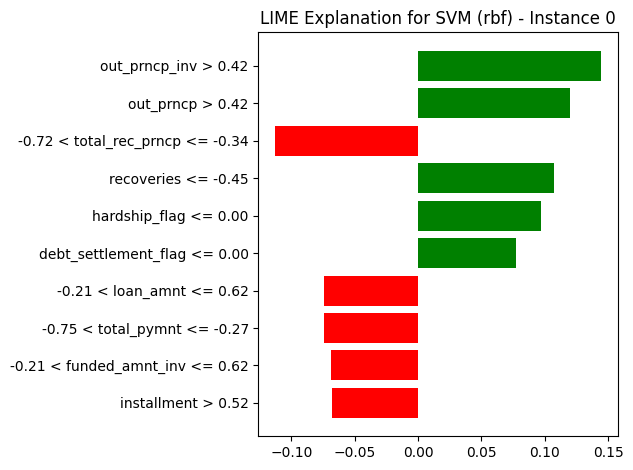

In [ ]:
# Plot the explanation
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.title(f'LIME Explanation for SVM ({best_model_type}) - Instance {instance_idx}')
plt.tight_layout()
plt.show()

LIME Explanation for a Single SVM Prediction

This LIME plot illustrates the **local explanation** of a single prediction made by the SVM model (RBF kernel).

✅ Main Positive Drivers (Increase Prediction):
- **High `out_prncp_inv`**: A strong indicator pushing the prediction up.

❌ Main Negative Drivers (Decrease Prediction):
- **Low `total_rec_prncp`**: Indicates little principal has been recovered, reducing confidence in repayment.
- **Higher values in `loan_amnt`, `total_pymnt`, etc.**: Larger loans or payments may be viewed as higher risk, decreasing the predicted outcome.


In [ ]:
# Print LIME explanation
print(f"LIME explanation for instance {instance_idx}:")
for feature, importance in exp.as_list():
    print(f"{feature}: {importance:.4f}")

LIME explanation for instance 0:
out_prncp_inv > 0.42: 0.1446
out_prncp > 0.42: 0.1201
-0.72 < total_rec_prncp <= -0.34: -0.1130
recoveries <= -0.45: 0.1075
hardship_flag <= 0.00: 0.0968
debt_settlement_flag <= 0.00: 0.0775
-0.21 < loan_amnt <= 0.62: -0.0745
-0.75 < total_pymnt <= -0.27: -0.0743
-0.21 < funded_amnt_inv <= 0.62: -0.0689
installment > 0.52: -0.0680


LIME Explanation – Instance #0 (SVM Model)

 🔼 Positive Influence (Increased Prediction Probability):
- **`out_prncp_inv > 0.42`**: +0.1446 *(strongest positive effect)*
- **`out_prncp > 0.42`**: +0.1201
- **`hardship_flag <= 0.00`**: +0.0968
- **`debt_settlement_flag <= 0.00`**: +0.0775

 🔽 Negative Influence (Decreased Prediction Probability):
- **`total_rec_prncp <= -0.34`**: −0.1130 *(strongest negative effect)*
- **`recoveries <= -0.45`**: −0.1075
- **`total_pymnt <= -0.27`**: −0.0743
- **`loan_amnt <= 0.62`**: −0.0745
- **`funded_amnt_inv <= 0.62`**: −0.0689
- **`installment > 0.52`**: −0.0680

#### 📝 Summary:
The SVM model's prediction was **strongly driven by high outstanding principal values** (`out_prncp_inv`, `out_prncp`) and the **absence of hardship or debt settlement**. On the other hand, **low recovery and payment-related metrics** (e.g., `total_rec_prncp`, `recoveries`, `total_pymnt`) reduced the prediction probability.


In [ ]:
# Display explanation
exp.show_in_notebook(show_table=True)

 LIME Feature Contributions – Instance #0

The table on the right breaks down **each feature’s contribution** to the model's predicted outcome for this instance.


🔼 Strong Positive Contributors (Increased Likelihood of Default):
- **`out_prncp_inv` (1.43):** Outstanding principal investment
- **`out_prncp` (1.43):** Outstanding principal balance

🔽 Moderate Negative Contributors (Decreased Likelihood of Default):
- **`total_rec_prncp` (−0.41):** Total principal recovered
- **`recoveries` (−0.45):** Amount recovered from previously charged-off loans

📊 Visualization Summary:
The central plot shows how each feature pushes the prediction **toward or away from default**.  
The final predicted outcome for this instance is a **1.00 probability of default** — a strong signal driven primarily by high outstanding balances and weak recovery performance.


### **4. SHAP Values**

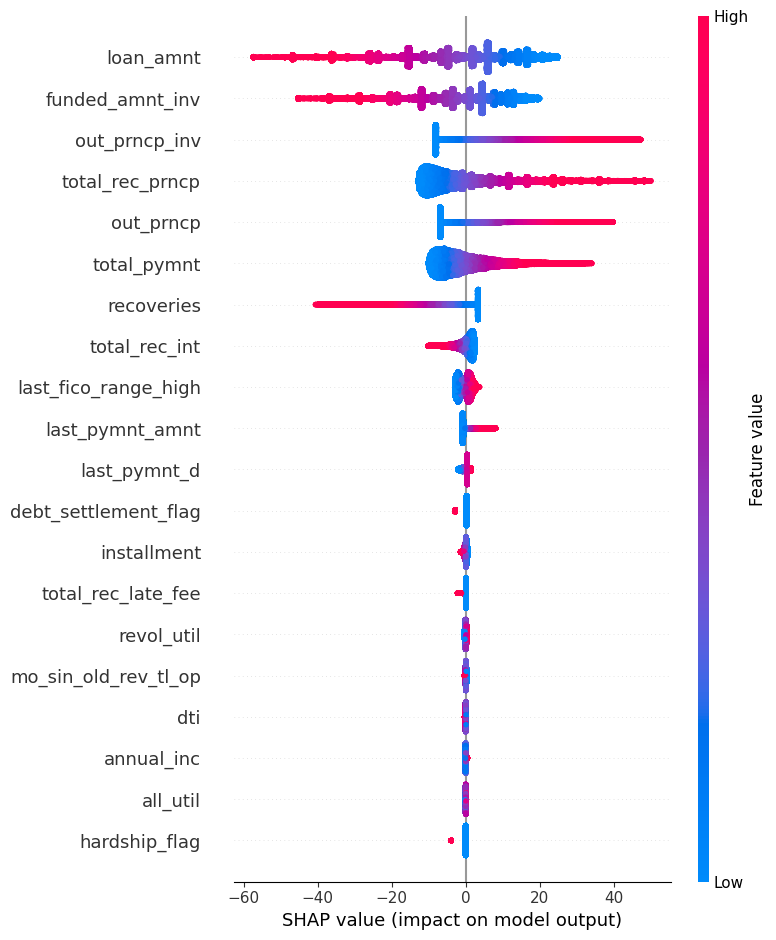

In [ ]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)

SHAP Value Plot – Feature Impact on Default Prediction

This SHAP (SHapley Additive exPlanations) plot visualizes how different features influence the model’s loan default predictions.

🔴 Strong Positive Impact (Pushes Prediction Toward Default):
- **`out_prncp_inv`**: Outstanding principal investment
- **`out_prncp`**: Outstanding principal
- **`total_pymnt`**: Total payment
- **`total_rec_prncp`** *(at high values)*: High principal recovery may be associated with risk in this context

🔵 Strong Negative Impact (Pushes Prediction Away From Default):
- **`total_rec_prncp`** *(at low values)*: Low recovery is protective in the model
- **`recoveries`**: Amount recovered from previously charged-off loans

📉 Low-Impact Features:
- Features like **`hardship_flag`**, **`annual_inc`**, etc., appear lower in the chart and have **minimal influence** on model output.

The direction of the SHAP value (left or right) indicates whether a feature **decreases or increases** the model's prediction for default. Color represents feature value (red = high, blue = low).
